In [1]:
import torch
import pandas as pd
import json
import pickle
import torch.utils.data
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import json
import math
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this exercise, we will will implement Text Classification with LSTM. We will use the online banking dataset for intent classification. A customer using the chat service of a bank asks questions, and we will classify to what category (intent) the question is related to.

The dataset contains 10,000 train samples, 3080 test samples over 77 different intents


You may download the dataset from [here](https://github.com/PolyAI-LDN/task-specific-datasets/tree/master/banking_data) (all `train.csv`, `test.csv`, and `categories.json`)

### 1. Loading the Data

In [2]:
train_data = pd.read_csv("banking_data/train.csv")
test_data = pd.read_csv("banking_data/test.csv")
categories_names = json.load(open("banking_data/categories.json"))

**[TO DO]** Create 2 dictionaries, one that maps the categries to discrete integers, and one that maps back those integers to their categories. These dictionary will be used to create the ground-truth labels

In [3]:
categories_labels = {categories_names[i] : i for i in range(len(categories_names))}
inv_categories_labels = {v: k for k, v in categories_labels.items()}

In [4]:
# we convert pandas data frames to lists using 1) the "values" funtion in pandas which first converts the pandas data frame into 
# a numpy array, followed by 2) "tolist" funtion in numpy. After that map your string labels to integers using the dictionaries 
# you defined above

data_train = train_data["text"].values.tolist()
label_train = train_data["category"].values.tolist()
label_train = [categories_labels[label_train[i]] for i in range(len(label_train))]

data_test = test_data["text"].values.tolist()
label_test = test_data["category"].values.tolist()
label_test = [categories_labels[label_test[i]] for i in range(len(label_test))]

In [5]:
# Visualize some random indices from the dataset

random_indices = np.random.randint(0, len(data_train), size=(3,)).tolist()
for index in random_indices:
    print("Query: {} \nLabel: {}".format(data_train[index], inv_categories_labels[label_train[index]]))
    print("-----------------")

Query: What forms of ID should I use for verification? 
Label: verify_my_identity
-----------------
Query: I have not seen any changes in my account balance(s) after making a transfer. 
Label: pending_transfer
-----------------
Query: Hello. I'm trying to transfer some money to a friend but it keeps getting rejected. can you help me? 
Label: failed_transfer
-----------------


### 2. Data Pre-processing

**[TO DO]** Now create a frequency dictionary which tells you the frequency of each word in your dataset. You may directly use the [Counter](https://www.geeksforgeeks.org/python-counter-objects-elements/) funtion from the collections library for this. Make sure to process your qiery first by converting it to lower-case and removing the question mark from the query!

In [6]:
word_freq = Counter()
for query in data_train:
    query_words = query.lower().replace('?', '').split()
    word_freq.update(query_words)

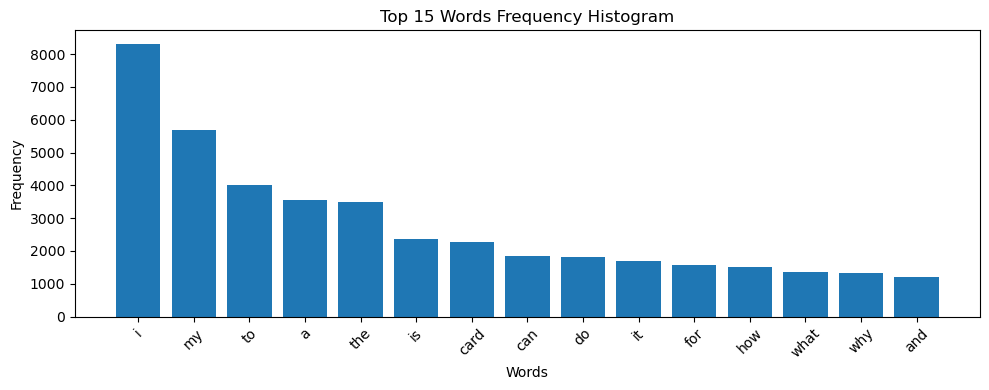

In [7]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**[TO DO]** Now create your vocabulary dictionary (word to indices): 

1) First select the words which occur at least 5 times (words which have a frequency of occurence of 5 or more). <br>
2) Then map each of those words to a unique integer. These integers will represent your words.  <br>
3) Finally, include 4 more additional special words: 
- The unknown word `<unk>` to indicate that a given word is unknown (this is to map rare words or word in the test dataset that were not seen during training).
- The `<start>` word which indicats the start of the sentence.
- The `<end>` word which indicats the end of the sentence.
- The `<pad>` word to indicate that the word is padded (rememeber from the slides, we pad the sequences with a shorter length than the maximum length we selected, to be able to load data in batches since sentences are of variable length). Make sure this padding word is assigned with an integer of 0!

4) Create the inverse dictionary which maps the indices back to their original words

What is your vocabulary size?

In [8]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print("Total words are: {}".format(len(word_map)))

Total words are: 1098


**[TO DO]** Define a funtion which takes in your input dataset and maximum length as an argument. This funtion will encode the questions using the vocabulary dictionary defined above. Remember to pad shorter seuqences than the maximum length to 0 using the `<pad>` token! If you encounter a word that is not in your vocabulary, encode it using the `<unk>` token.

In [9]:
def encode_text(data, max_len):
    
    encoded_texts = []
    for query in data:
        query_words = query.lower().replace('?', '').split()
        words = query_words[:max_len]
        tokenized = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
        encoded_texts.append(tokenized)
        
    return encoded_texts

In [10]:
encoded_texts = encode_text(data_train, max_len = 15)
encoded_texts_test = encode_text(data_test, max_len = 15)

In [11]:
# test one sample
example_tokens = encoded_texts[0]
print(" ".join([rev_word_map[t] for t in example_tokens]))

i am still waiting on my card <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## **Define Dataset and Data Loader**

In [12]:
X_train = torch.tensor(encoded_texts)    # (number_of_samples, max_length)
y_train = torch.LongTensor(label_train)  # (number_of_samples)
X_test = torch.tensor(encoded_texts_test)
y_test = torch.LongTensor(label_test)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=128, 
                                          shuffle=True)

In [13]:
input, labels = next(iter(train_loader))
print(input.shape)
print(labels.shape)

torch.Size([128, 15])
torch.Size([128])


## **Network**

**[TO DO]** Define your LSTM Network:

$\tilde{C}_t=\tanh \left(W_C \cdot\left[h_{t-1}, x_t\right]+b_C\right)$<br>
$i_t=\sigma\left(W_i \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>
$f_t=\sigma\left(W_f \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>
$C_t=f_t * C_{t-1}+i_t * \tilde{C}_t$ <br>
$o_t=\sigma\left(W_o \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>
$h_t=o_t * \tanh \left(C_t\right)$

Loop over your timesteps, run the LSTM cell for each input, and save the hidden states for each cell in a list. Then convert this list into a PyTorch Tensor using [torch.stack](https://pytorch.org/docs/stable/generated/torch.stack.html) or [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)

In [14]:
class LSTM(nn.Module):
    
    def __init__(self, input_sz, hidden_sz):
        
        super(LSTM, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #c_t: new memory (the new memory)
        self.W_c = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #i_t: input gate (how much to take from the new memory)
        self.W_i = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #f_t: forget gate (how much to forget from the old memory)
        self.W_f = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #o_t: output gate (how much to take from the new memory to represent the output)
        self.W_o = nn.Linear(input_sz + hidden_sz, hidden_sz)

        self.init_weights()
        
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()  
        
        # initialize h_t and c_t to zeros
        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device), 
                    torch.zeros(batch_size,self.hidden_size).to(device))
        
        hidden_states = []
        
        for t in range(seq_len):
            # get the input at the current timestep 
            x_t = x[:, t, :]
            
            # run the LSTM Cell
            common_input = torch.cat([x_t, h_t], dim = -1)
            
            new_c = torch.tanh(self.W_c(common_input))
            i_t = torch.sigmoid(self.W_i(common_input))
            f_t = torch.sigmoid(self.W_f(common_input))
            c_t = f_t * c_t + i_t * new_c
            
            o_t = torch.sigmoid(self.W_o(common_input))
            h_t = o_t * torch.tanh(c_t)
            
            # save the hidden states in a list
            hidden_states.append(h_t.unsqueeze(1))
            
        hidden_states = torch.cat(hidden_states, dim = 1)
            
        return hidden_states

In [15]:
# test the lstm with a random input of shape (10,100,128), which represents (batch_size, seq_length, input_embedding_dim). 
# the output shape should be  (batch_size, seq_length, hidden_lstm_size)
my_lstm = LSTM(128, 512).to(device)
random_input = torch.randn(10,100,128).to(device)  
output = my_lstm(random_input)
print(output.shape)

torch.Size([10, 100, 512])


What are the number of parameters in an LSTM?

In [ ]:
print("Number of parameters for my lstm:", sum(p.numel() for p in my_lstm.parameters()))

**[TO DO]** Define your whole model which includes:

1) The [embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)<br>
2) LSTM you defined above<br>
3) The classifier. 

Either take the mean or last hidden state as the feature vector representing the question, which you will run through your classifier. 

1098

In [ ]:
class Net(nn.Module):
    
    def __init__(self, input_embedding_size, hidden_size, pooling_type = 'last_hidden_state'):
        
        super().__init__()

        self.embedding = nn.Embedding(len(word_map), input_embedding_size)
        self.lstm = LSTM(input_embedding_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, 77)
        self.pooling_type = pooling_type
        
    def forward(self, x):
        
        # x is of shape (batch_size, max_seq_length)
        x = self.embedding(x)   # (batch_size, seq_len, embed_dim)
        x = self.lstm(x)        # (batch_size, seq_len, hidden_size)

        if self.pooling_type == "last_hidden_state":
            x = x[:, -1, :]     # (batch_size, hidden_size)
        else:
            x = x.mean(1)       # (batch_size, hidden_size)

        x = self.classifier(x)         # (batch_size, 77)
        return x

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # move to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # run forward-backward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = train_loss / (batch_idx+1)
    epoch_acc = 100.* correct / total
    print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, 
                                                                                       len(train_loader),
                                                                                       epoch_loss, 
                                                                                       epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
model = Net(input_embedding_size = 256, hidden_size = 512).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
epochs = 10

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Curve')

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')

**[TO Do]** Write the test loop code to get the final test accuracy (no need to get the test loss). You should get a test accuracy of around **85%**

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

acc = 100.*correct/total
print('Test Accuracy: {:.3f}'.format(acc))

In [ ]:
sample = inputs[0]
sentence = ' '.join([rev_word_map[w] for w in sample.tolist()])
print(sentence)

output = model(sample.unsqueeze(0))
prob, pred = F.softmax(output, dim = -1).max(1)

print('index {} is predicted with a probability of {}'.format(pred.item(), prob.item()))
print('index {} is {}'.format(pred.item(), inv_categories_labels[pred.item()]))